In [1]:
D = 200_000
GAMMA = 0.99
LR = 0.00003

NUM_EPISODES = 50
SEQUENCE_LENGTH = 4
BATCH_SIZE = 512

EPS_NUM_STEPS = 30000
EPS_START = 0.5
EPS_END = 0.15
EPS_DECAY = (EPS_START - EPS_END) / (EPS_NUM_STEPS)

load_model = False
model_name = "2023_04_14_22_32_04"

In [2]:
import gym
import torch
import torchvision
from IPython.display import clear_output

torch.set_printoptions(profile="full")

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

env = gym.make("ALE/Enduro-v5", obs_type="grayscale", render_mode='rgb_array', frameskip=4)

cuda


C:\Users\glucas\Desktop\test\torch_env\Lib\site-packages\gym\utils\passive_env_checker.py:31: UserWarning: WARN: A Box observation space has an unconventional shape (neither an image, nor a 1D vector). We recommend flattening the observation to have only a 1D vector or use a custom policy to properly process the data. Actual observation shape: (210, 160)
  logger.warn(


In [3]:
from collections import deque
import random

CROP_DIMS = 60, 40, 95, 95
RESIZE = 40, 40

class Memory:
    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = deque([], maxlen=capacity)
    
    def __len__(self):
        return len(self.memory)
    
    def push(self, experience):
        self.memory.append(experience)
    
    # for replay memory
    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)
    
    # for sequence
    def phi(self, new_state):
        x = torch.tensor(new_state, dtype=torch.float32, device=device).unsqueeze(0)/255
        x = torchvision.transforms.functional.crop(x, *CROP_DIMS)
        x = torchvision.transforms.Resize(RESIZE, antialias=True)(x)
        x = torchvision.transforms.Normalize(mean=x.mean(), std=x.std())(x)
        self.push(x)
        
    def render(self):
        if len(self.memory) < SEQUENCE_LENGTH:
            return False, None

        return True, torch.cat(tuple(self.memory), 0)
    
    def clear(self):
        self.memory.clear()
        

torch.Size([4, 40, 40])


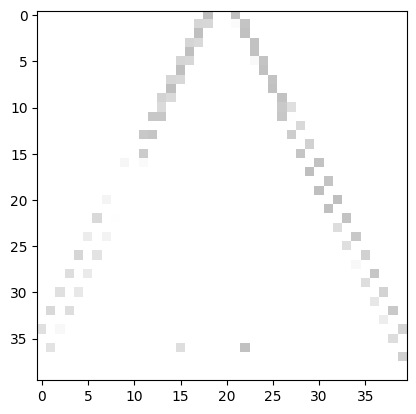

In [4]:
from matplotlib import pyplot as plt

"""
while True:
    env.step(env.action_space.sample())
    env.render()
"""

# DEBUGGING PHI

sequence = Memory(SEQUENCE_LENGTH)

state, info = env.reset()

sequence.phi(state)
rendered, x = sequence.render()
while not(rendered):
    sequence.phi(state)
    rendered, x = sequence.render()

print(x.shape)
img = x.cpu().numpy().transpose((1, 2, 0))
plt.imshow(img)

def batch_images(batch):
    grid = torchvision.utils.make_grid(batch)
    grid = grid.cpu().numpy()
    plt.imshow(grid.transpose([1,2,0]))
    plt.show()
    
def forwad_batch_images(batch):
    print(batch.shape)
    batch = batch.unsqueeze(0)
    print(batch.shape)
    batch = batch.transpose(0,1)
    print(batch.shape)
    grid = torchvision.utils.make_grid(batch)
    print(grid.shape)
    grid = grid.cpu().detach().numpy()
    plt.imshow(grid.transpose([1,2,0]))
    plt.show()

In [5]:
import torch.nn as nn
import torch.nn.functional as F


class DQN(nn.Module):
    def __init__(self):
        super(DQN, self).__init__()
        # 3x40x40
        self.conv_0 = nn.Conv2d(4, 12, (4, 4), stride=1) # 3x37x37
        self.maxpool_1 = nn.MaxPool2d(2, stride=2)
        self.conv_1 = nn.Conv2d(12, 24, (3, 3), stride=1) # 4x6x6
        self.maxpool_2 = nn.MaxPool2d(2, stride=2)
        self.conv_2 = nn.Conv2d(24, 48, (2, 2), stride=1) # 4x6x6
        self.maxpool_3 = nn.MaxPool2d(2, stride=2)
        self.flatten = nn.Flatten() # 4x6x6
        self.hidden_1 = nn.Linear(432, 256)
        self.a = nn.Linear(256, 3)
        
    def forward(self, x):
        #clear_output()
        #print(x.shape)
        #forwad_batch_images(x[0])
        x = F.relu(self.conv_0(x))
        #forwad_batch_images(x[0])
        x = self.maxpool_1(x)
        #forwad_batch_images(x[0])
        x = F.relu(self.conv_1(x))
        #forwad_batch_images(x[0])
        x = self.maxpool_2(x)
        #forwad_batch_images(x[0])
        x = F.relu(self.conv_2(x))
        #forwad_batch_images(x[0])
        x = self.maxpool_3(x)
        #forwad_batch_images(x[0])
        x = self.flatten(x)
        #print(x.shape)
        x = F.relu(self.hidden_1(x))
        #print(x.shape)
        x = self.a(x)
        #print(x.shape)
        #input()
        return x
    
    def _img_forward(self, x):
        clear_output()
        print(x.shape)
        forwad_batch_images(x[0])
        x = F.relu(self.conv_0(x))
        forwad_batch_images(x[0])
        x = self.maxpool_1(x)
        forwad_batch_images(x[0])
        x = F.relu(self.conv_1(x))
        forwad_batch_images(x[0])
        x = self.maxpool_2(x)
        forwad_batch_images(x[0])
        x = F.relu(self.conv_2(x))
        forwad_batch_images(x[0])
        x = self.maxpool_3(x)
        forwad_batch_images(x[0])
        x = self.flatten(x)
        print(x.shape)
        x = F.relu(self.hidden_1(x))
        print(x.shape)
        x = self.a(x)
        print(x.shape)
        time.sleep(1)
        return x
    
    def q_train(self, target_net, optimizer, loss_fn, batch):
        
        states, actions, rewards, next_states = *zip(*batch), # let the ',' to not give syntax error
        
        states = torch.stack(states)
        actions = torch.cat(actions)
        rewards = torch.cat(rewards)
        
        
        # next_states = torch.stack(next_states)
        
        non_final_states_mask = torch.tensor(tuple(map(lambda s: s is not None, next_states)), device=device)
        #non_final_next_states = next_states[non_final_states_mask]
        
        non_final_next_states = torch.stack([s for s in next_states if s is not None])
        
        max_action_qvalues = torch.zeros(BATCH_SIZE, device=device)
        with torch.no_grad():
            max_action_qvalues[non_final_states_mask] = target_net(non_final_next_states).max(1)[0]
        
        
        # Set yj for terminal and non-terminal phij+1
        y = rewards + GAMMA * max_action_qvalues
        
        qvalues = self(states).gather(1, actions)
        loss = loss_fn(qvalues, y.unsqueeze(1))
        optimizer.zero_grad()
        
        loss.backward()
        
        torch.nn.utils.clip_grad_value_(self.parameters(), 100)
        optimizer.step()
        
        return loss

In [6]:
import time
from itertools import count
from tensorboardX import SummaryWriter

timestr = time.strftime("%Y_%m_%d_%H_%M_%S")

# Initiliaze replay memory D to capacity N
replay_memory = Memory(D)
sequence = Memory(SEQUENCE_LENGTH)

# Initialize action-value function Q with random weights

policy_net = DQN().to(device) # used to store teta
target_net = DQN().to(device) # used to store teta-1

if load_model:
    policy_net.load_state_dict(torch.load(f'./saved_models/{model_name}/policy_net'))
    
target_net.load_state_dict(policy_net.state_dict())

optimizer = torch.optim.Adam(policy_net.parameters(), lr=LR)
loss_fn = nn.MSELoss()

epsilon = EPS_START
steps = 0
episode = 0

In [ ]:


env.close()
env = gym.make("ALE/Enduro-v5", obs_type="grayscale", render_mode='rgb_array', frameskip=4)

with SummaryWriter(logdir="runs/"+timestr) as writer:
    
    while steps < D*10 -50:
        
        ep_rewards = 0
        ep_qvalues = 0
        ep_loss = 0
        
        # Initialise sequence s1 = {x1} and preprocessed sequenced φ1 = φ(s1)
        sequence.clear()
        observation, info = env.reset()
        sequence.phi(observation)

        was_rendered = False
        for t in count():
            
            if was_rendered:
                q_value_action = policy_net(state.unsqueeze(0)).max(1)
                ep_qvalues += abs(q_value_action[0].item())
            
            # With probability eps select a random action at
            epsilon = epsilon - EPS_DECAY if epsilon > EPS_END else EPS_END
            if random.uniform(0, 1) < epsilon:
                action = torch.tensor([[random.randint(0, 2)]], device=device, dtype=torch.long)

            # otherwise select at = maxaQ*(phi(st), a; teta)
            else:
                if was_rendered:
                    action = q_value_action[1].view(1,1)
                else:
                    action = torch.tensor([[random.randint(0, 2)]], device=device, dtype=torch.long)

            # Execute action at in emulator and observe reward rt and image xt+1
            observation, reward, terminated, truncated, _ = env.step(action.item() + 1)
            
            # reward -= 0.01
            ep_rewards += reward
            
            reward = torch.tensor([reward], device=device, dtype=torch.float32)
            
            # env.render()

            # Set st+1 = st, at, xt+1 and preprocess phit+1 = phi(st+1)
            if terminated:
                next_state = None # ordem provavelmente errada
            else:
                sequence.phi(observation)
                rendered, next_state = sequence.render()  

            if was_rendered:
                replay_memory.push((state, action, reward, next_state))
                if len(replay_memory) > BATCH_SIZE:
                    loss = policy_net.q_train(target_net, optimizer, loss_fn, replay_memory.sample(BATCH_SIZE)).item()
                    ep_loss += loss
                    if t % 100 == 0:

                        clear_output(wait=True)
                        #img = state.cpu().numpy().transpose((1, 2, 0))
                        #plt.imshow(img)
                        #plt.show()
                        print('loss:', loss, 'step:', steps, 'epsilon:', epsilon, 'last_reward:', reward, 'ep:', episode)
                        
                        writer.add_scalar("Loss", ep_loss, steps)
                        writer.add_scalar("Reward", ep_rewards, steps)
                        writer.add_scalar("Qvalue", ep_qvalues, steps)
                        writer.flush()
                        ep_rewards = 0
                        ep_qvalues = 0
                        ep_loss = 0
                        
                    if t % 2000 == 0:
                        target_net.load_state_dict(policy_net.state_dict())
                        
            was_rendered = rendered
            state = next_state
            steps += 1
            if terminated or truncated or steps > D*10-50:
                break
        """
        writer.add_scalar("Loss", ep_loss / t, episode)
        writer.add_scalar("Reward", ep_rewards / t, episode)
        writer.add_scalar("Qvalue", ep_qvalues / t, episode)
        """
        episode += 1
        # writer.flush()

loss: 0.02076195552945137 step: 19640 epsilon: 0.2708549999995891 last_reward: tensor([0.], device='cuda:0') ep: 5


In [ ]:
import os

save_model_dir = './saved_models'

if not os.path.exists(f'{save_model_dir}'):
    os.mkdir(f'{save_model_dir}')
if not os.path.exists(f'{save_model_dir}/{timestr}'):
    os.mkdir(f'{save_model_dir}/{timestr}')

torch.save(policy_net.state_dict(), f'{save_model_dir}/{timestr}/policy_net')
torch.save(target_net.state_dict(), f'{save_model_dir}/{timestr}/target_net')

In [ ]:
env.close()
env = gym.make("ALE/Enduro-v5", obs_type="grayscale", render_mode='human', frameskip=4)

while True:
        sequence.clear()
        observation, info = env.reset()
        sequence.phi(observation)
        env.render()
        was_rendered = False
        for t in count():
            
            if was_rendered:
                q_value_action = policy_net(state.unsqueeze(0)).max(1)
                action = q_value_action[1].view(1,1)
            else:
                action = torch.tensor([[random.randint(0,2)]], device=device, dtype=torch.long)
                
            # Execute action at in emulator and observe reward rt and image xt+1
            observation, reward, terminated, truncated, _ = env.step(action.item()+1)
            env.render()
            if terminated:
                next_state = None # ordem provavelmente errada
            else:
                sequence.phi(observation)
                rendered, next_state = sequence.render()  

            was_rendered = rendered
            
            state = next_state
            if terminated or truncated:
                break